In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Parte 1:
1. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.
2. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White patch.

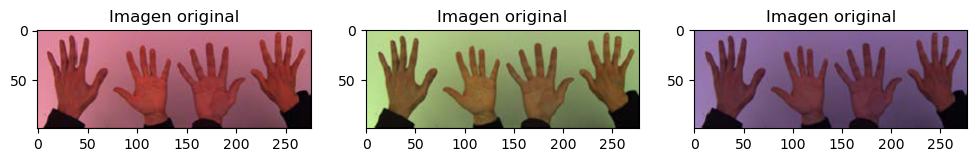

In [3]:
# Carga de las imágenes de las manos 
# Todas las imágenes .png
# Se transforman de BGR a RGB

hands_red_org=cv.imread('white_patch/test_red.png')
hands_red = cv.cvtColor(hands_red_org, cv.COLOR_BGR2RGB)
hands_green_org=cv.imread('white_patch/test_green.png')
hands_green = cv.cvtColor(hands_green_org, cv.COLOR_BGR2RGB)
hands_blue_org=cv.imread('white_patch/test_blue.png')
hands_blue = cv.cvtColor(hands_blue_org, cv.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 12))

ax1=fig.add_subplot(1,3,1)
ax1.imshow(hands_red)
ax1.set_title("Imagen original")

ax2=fig.add_subplot(1,3,2)
ax2.imshow(hands_green)
ax2.set_title("Imagen original")

ax3=fig.add_subplot(1,3,3)
ax3.imshow(hands_blue)
ax3.set_title("Imagen original")

plt.show()

Se construye una función que aplique el filtro white patch usando el valor máximo de cada canal o el percentil elegido. La función toma imágenes rgb. 

In [4]:
def white_patch(img: np.ndarray,
                mode: str = "max",
                percentile: float = 99.0) -> np.array:
    """
    Parameters
    ----------
    image : np.ndarray
        Imagen RGB (uint8 o float) con forma (H, W, 3).
    mode : {"max", "percentile"}
        - "max": usa el valor máximo de cada canal como referencia.
        - "percentile": usa el percentil indicado para cada canal.
    percentile : float
        Percentil a usar si mode == "percentile". Entre 0 y 100.
    Returns
    -------
    np.ndarray
        Imagen corregida con el mismo dtype que la original.
    """
    image=img.astype(np.float32,copy=False)   
    r,g,b=cv.split(image)  
    if mode == 'max':
        r_ref=np.max(r)
        g_ref=np.max(g)
        b_ref=np.max(b)
    elif mode == 'percentile' and (0.0<percentile<=100.0):
        r_ref=np.percentile(r,percentile)
        g_ref=np.percentile(g,percentile)
        b_ref=np.percentile(b,percentile)
    else:
        raise ValueError('modo incorrecto o percentil inválido')
    
    r_scale=255/np.clip(r_ref,1e-6,None)
    g_scale=255/np.clip(g_ref,1e-6,None)
    b_scale=255/np.clip(b_ref,1e-6,None)

    img_corr = cv.merge([r*r_scale, g*g_scale, b*b_scale]) 
    image_corrected=np.clip(img_corr,0,255).astype(np.uint8)
    return image_corrected


Se construye una función para visualizar la imagen original, las imágenes transformadas y el correspondiente histograma por canal de cada imagen.

In [5]:
def show_comparison(image_rgb: np.ndarray,
                                          percentile: float = 95.0,
                                          bins: int = 256) -> None:
    """
    Muestra original, white patch (max) y white patch (percentil) con histogramas RGB.

    Parameters
    ----------
    image_rgb : np.ndarray
        Imagen RGB (H, W, 3) uint8 (0-255).
    percentile : float
        Percentil para white patch (percentile).
    bins : int
        Número de bins para los histogramas por canal.
    """
    corrected_max = np.array(white_patch(image_rgb, mode="max"))
    corrected_pct = np.array(white_patch(image_rgb,
                                         mode="percentile",
                                         percentile=percentile))

    entries = [
        ("Original", image_rgb),
        ("White patch (max)", corrected_max),
        (f"White patch (percentile {percentile:g})", corrected_pct),
    ]

    fig, axes = plt.subplots(len(entries), 2, figsize=(12, 12))
    
    channel_info = [
        ("R", "red"),
        ("G", "green"),
        ("B", "blue"),
    ]
    hist_range = (0, 255)
    for row, (title, img) in enumerate(entries):
        ax_img = axes[row, 0]
        ax_hist = axes[row, 1]

        ax_img.imshow(img)
        ax_img.set_title(title)
        ax_img.axis("off")

        for (_, color), channel_idx in zip(channel_info, range(3)):
            channel_data = img[:,:, channel_idx].ravel()
            ax_hist.hist(channel_data,
                         bins=bins,
                         range=hist_range,
                         color=color,
                         alpha=0.45,
                         label=color.upper())

        ax_hist.set_xlim(hist_range)
        ax_hist.set_ylabel("Frecuencia")
        ax_hist.grid(alpha=0.2, linestyle="--")
        if row == 0:
            ax_hist.set_title("Distribución de canales")
            ax_hist.legend()

    axes[-1, 1].set_xlabel("Intensidad")
    plt.tight_layout()
    plt.show()

#### Imágenes de las manos

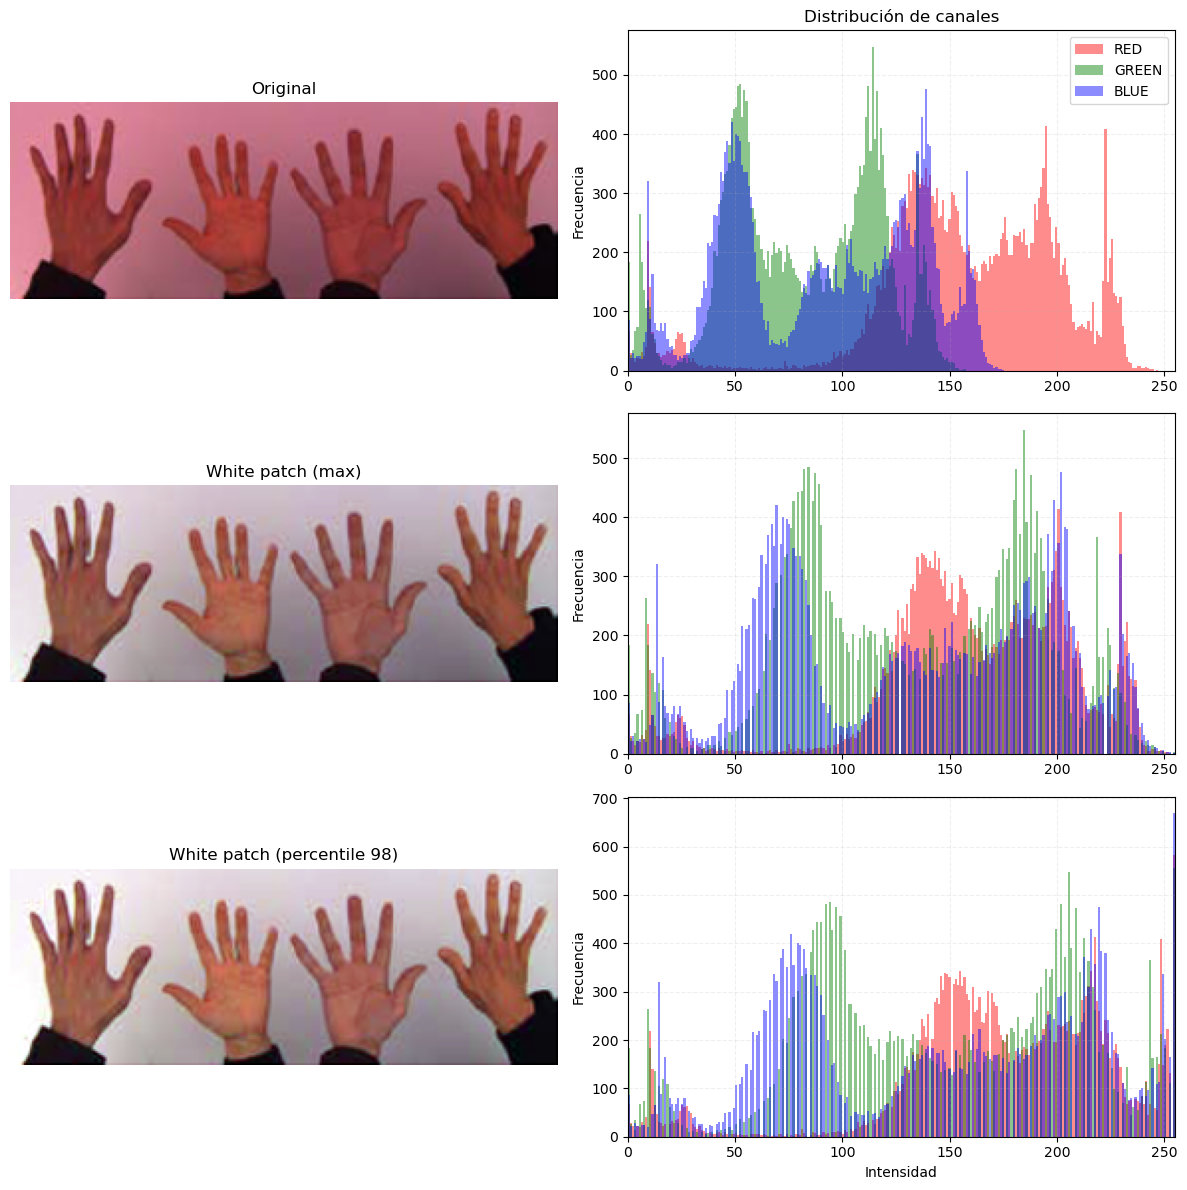

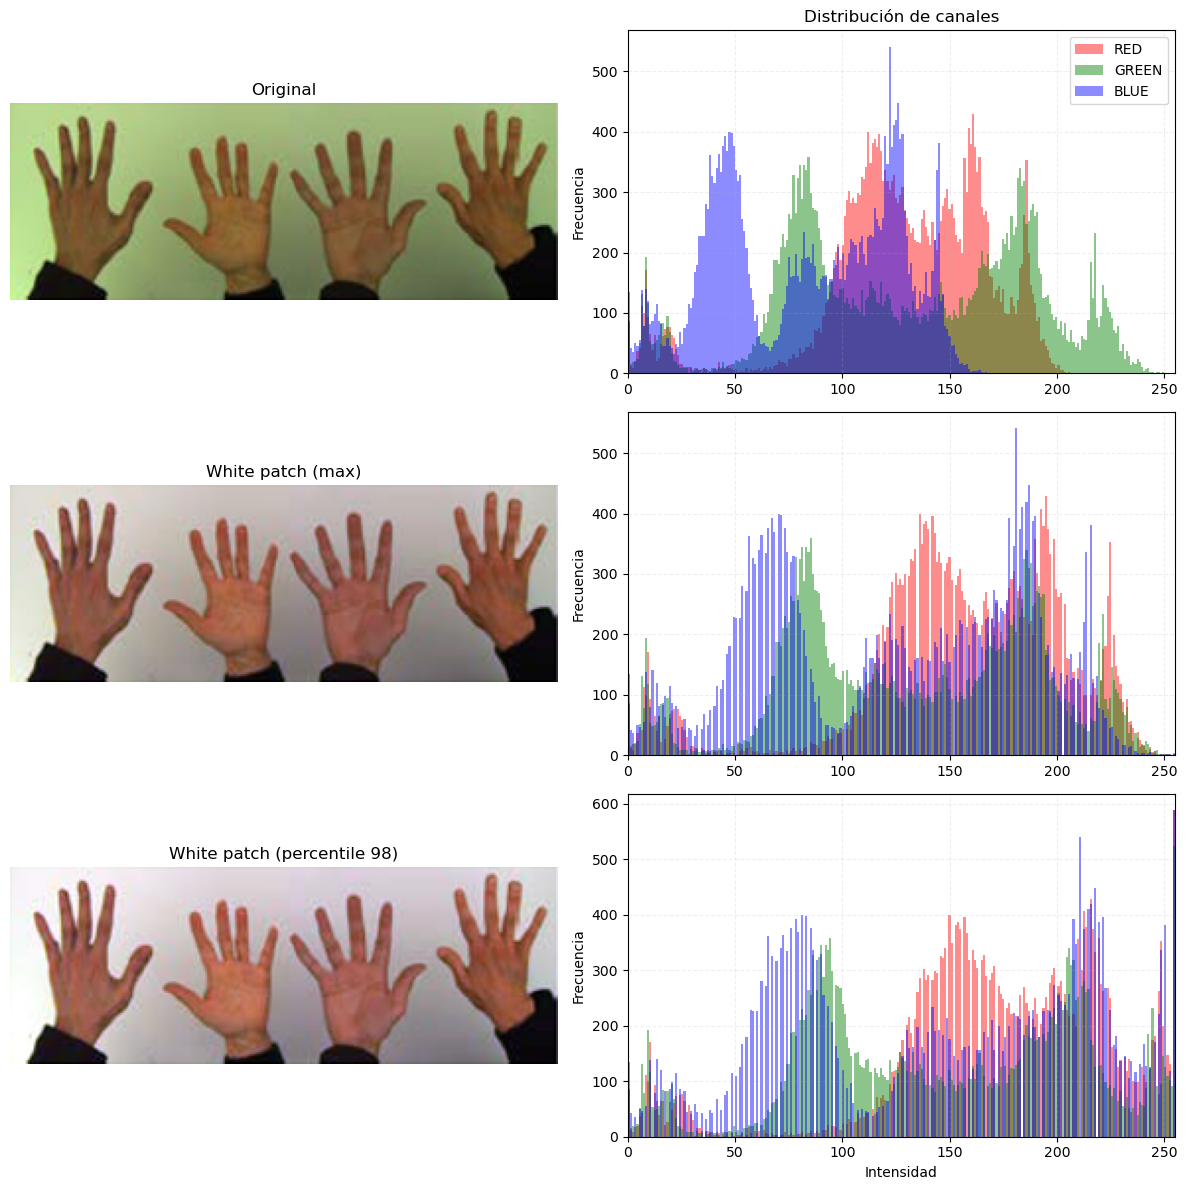

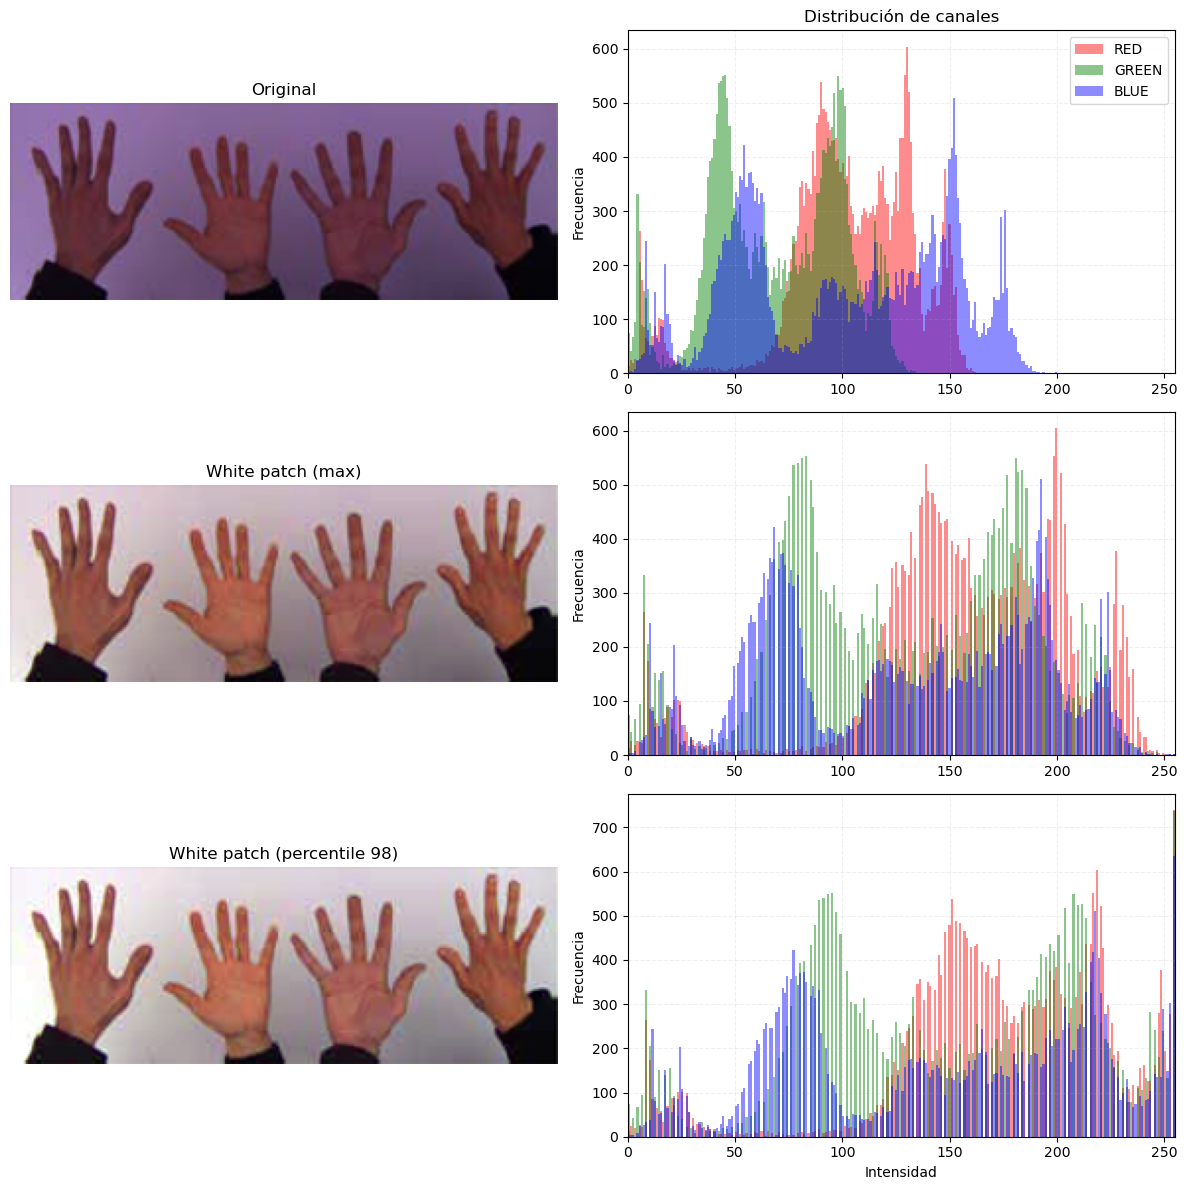

In [6]:
show_comparison(hands_red,98)
show_comparison(hands_green,98)
show_comparison(hands_blue,98)

#### Discusión 
Análisis de la primera foto (iluminación roja)
En la **imagen original**, se observa que en histograma de R contienen valores más elevados (desplazado hacia la derecha) que los correspondientes histogramas de G y B.
**White patch (max)**
En el histograma, los tres canales ahora ocupan un rango más amplio y se superponen más, esto evidencia una mejor distribución del color, se ven pequeñas diferencias entre los picos donde el azul se observa ligeramente más fuerte. Como resultado la imagen tiene cierta palidez.
**White patch (percentile)**
Muestra un mejor que desempeño  que White patch (max) expandiendo más los histogramas y generando distribuciones de mayor similitud para R, G, y B. Como resultado se obtiene una imagen con tonos de piel y fondo más realistas y equilibrados, sin la palidez mencionada anteriormente.
Este análisis y resultado se puede extender a las otras dos imágenes restantes.
La elección particular del percentile 98 corresponde a una búsqueda manual para el cual los autores consideraron que el resultado óptimo. 

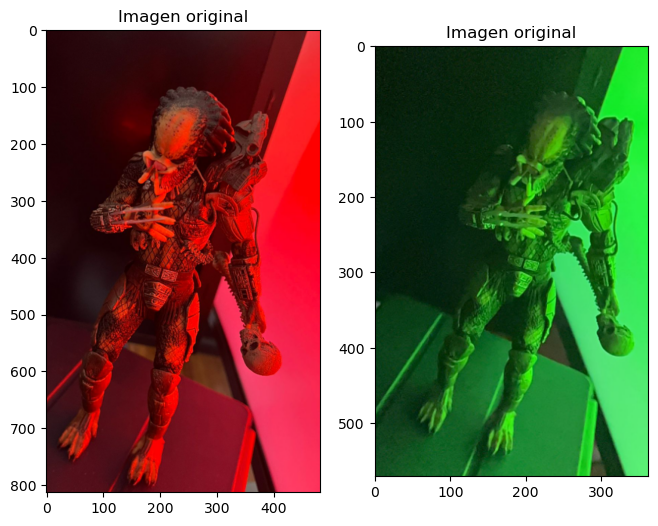

In [7]:
# Carga de las imágenes del depredador
# Todas las imágenes .png
# Se transforman de BGR a RGB

dp_red_org=cv.imread('white_patch/wp_red.png')
dp_red = cv.cvtColor(dp_red_org, cv.COLOR_BGR2RGB)
dp_green_org=cv.imread('white_patch/wp_green.png')
dp_green = cv.cvtColor(dp_green_org, cv.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 12))

ax1=fig.add_subplot(1,3,1)
ax1.imshow(dp_red)
ax1.set_title("Imagen original")

ax2=fig.add_subplot(1,3,2)
ax2.imshow(dp_green)
ax2.set_title("Imagen original")

plt.show()

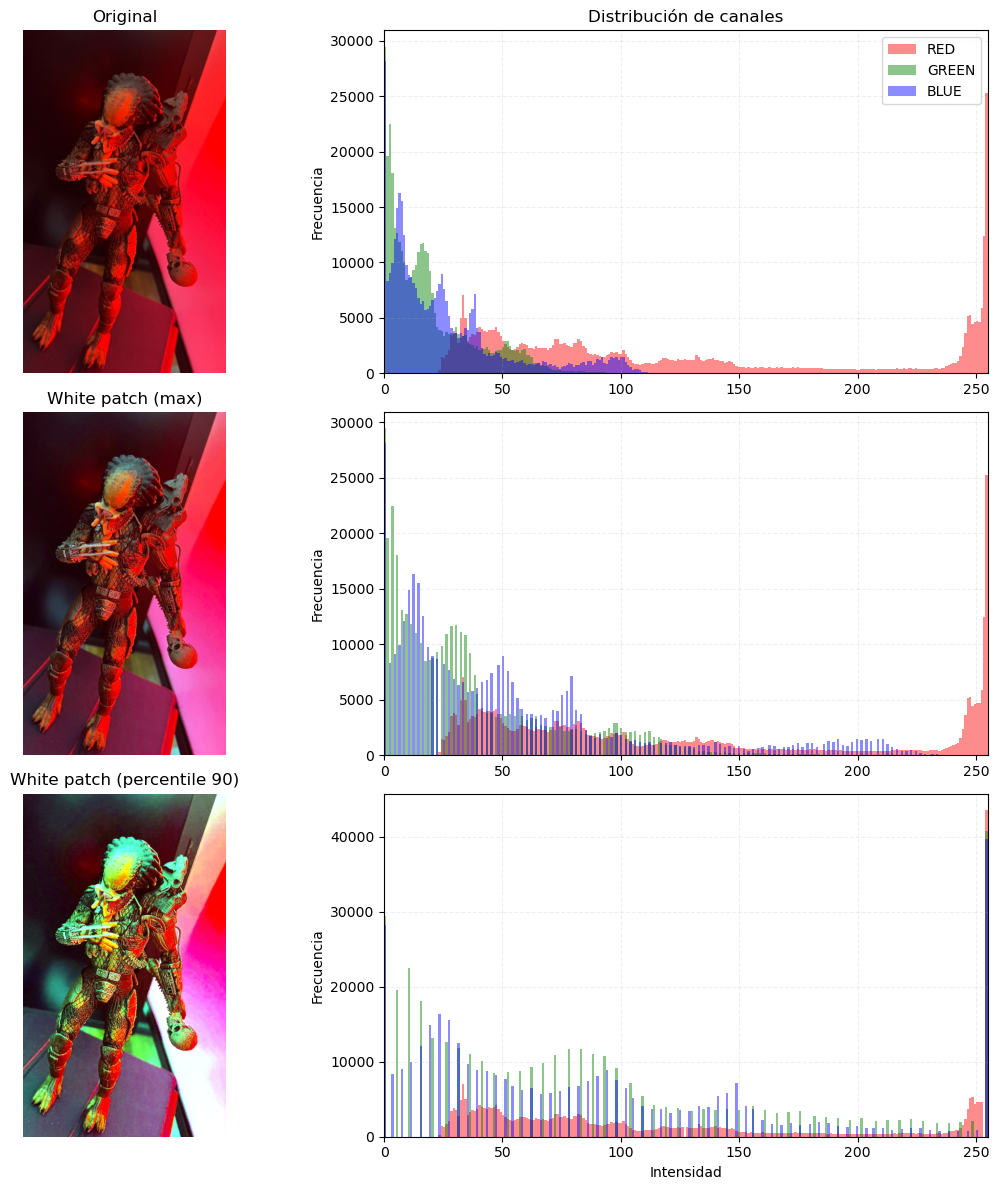

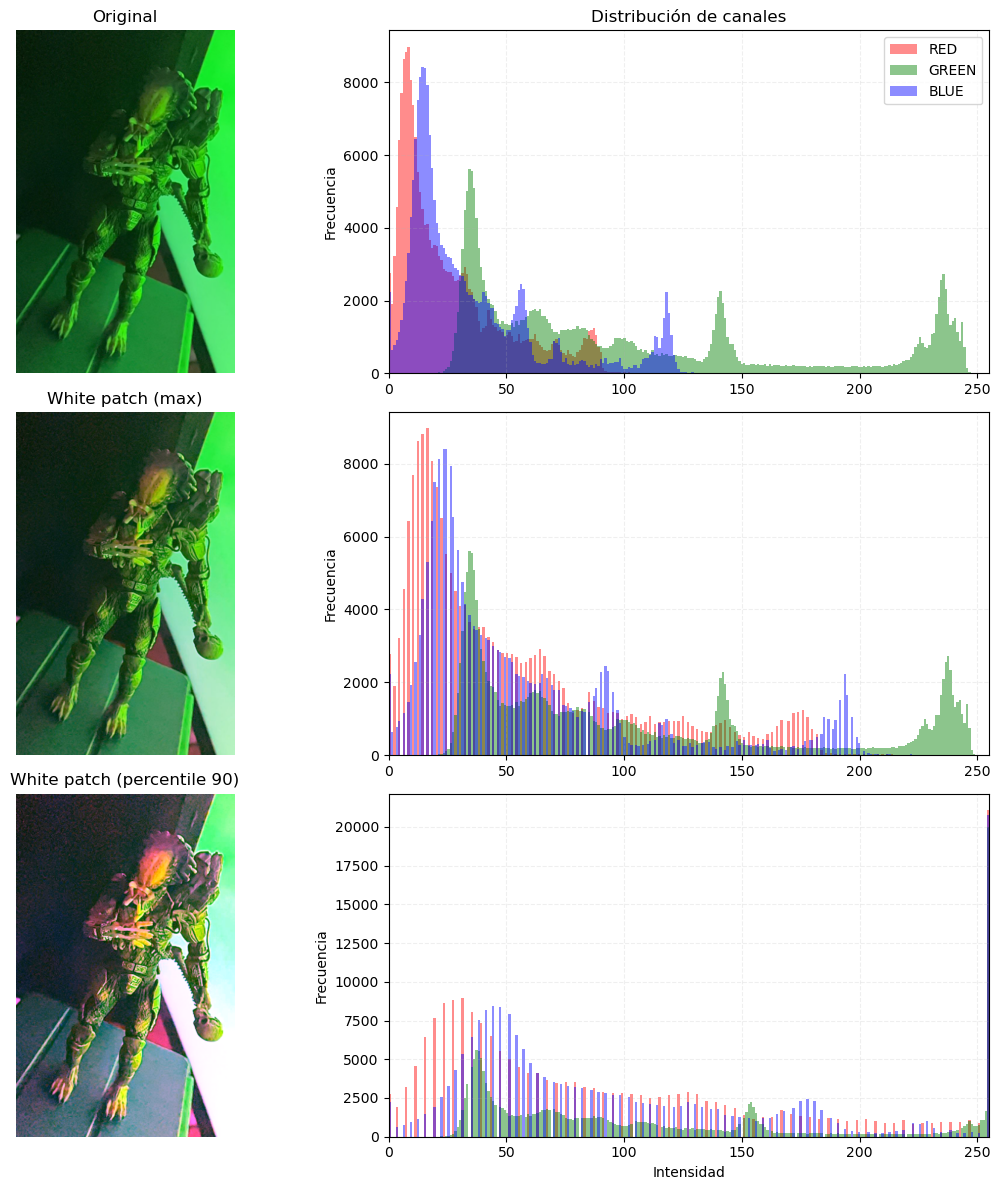

In [83]:
show_comparison(dp_red,90)
show_comparison(dp_green,90)

#### Discusión 
Análisis de las fotos del **Depredador formato .png**

En ambas imágenes, la iluminación introduce una dominante de color muy fuerte (rojiza en la primera imagen, verdosa en la segunda). Esto se observa claramente en los histogramas iniciales (imagen original): un canal sobresale ampliamente sobre los otros, provocando que toda la escena quede "pintada".
Análisis de la foto iluminada con rojo.
**White patch (max)**
La corrección reduce la dominante roja, pero no de manera tan notorio como en el ejemplo de las manos. Hay zonas de aspecto menos natural aunque aparecen detalles y "texturas" que no lograban apreciarse en la imagen original.
**White patch (percentile)**
En este caso nuevamente muestra un mejor desempeño que White patch (max) a los fines de resaltar detalles y "texturas". Los histogramas de B y G se expanden pero la ausencia de esas componente de color en al imagen original provoca un resultado con colores no naturales zonas con saturación.
El análisis puede trasladarse al la imagen iluminada con luz verde.
La elección particular del percentile 90 corresponde a una búsqueda manual para el cual los autores consideraron que el resultado óptimo. 

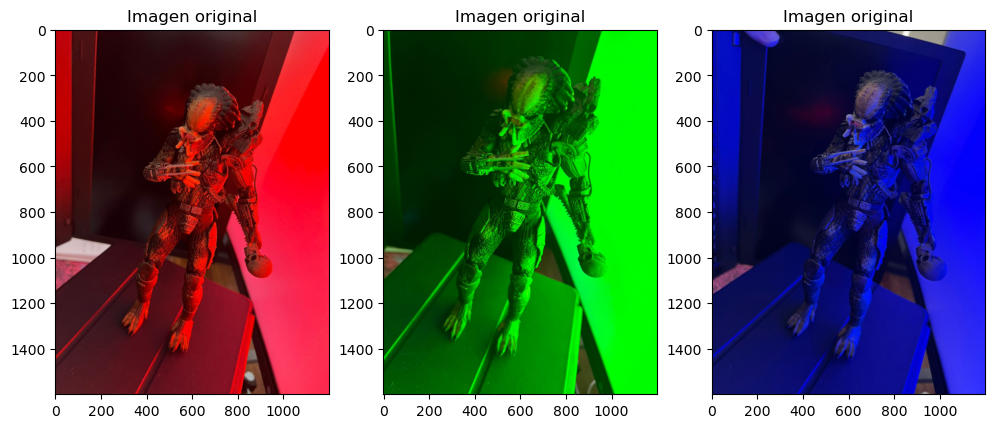

In [8]:
# Carga de las imágenes del depredador
# Todas las imágenes .jpg

dpj_red_org=cv.imread('white_patch/wp_red2.jpg')
dpj_red = cv.cvtColor(dpj_red_org, cv.COLOR_BGR2RGB)
dpj_green_org=cv.imread('white_patch/wp_green2.jpg')
dpj_green = cv.cvtColor(dpj_green_org, cv.COLOR_BGR2RGB)
dpj_blue_org=cv.imread('white_patch/wp_blue.jpg')
dpj_blue = cv.cvtColor(dpj_blue_org, cv.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 12))

ax1=fig.add_subplot(1,3,1)
ax1.imshow(dpj_red)
ax1.set_title("Imagen original")

ax2=fig.add_subplot(1,3,2)
ax2.imshow(dpj_green)
ax2.set_title("Imagen original")

ax3=fig.add_subplot(1,3,3)
ax3.imshow(dpj_blue)
ax3.set_title("Imagen original")
plt.show()

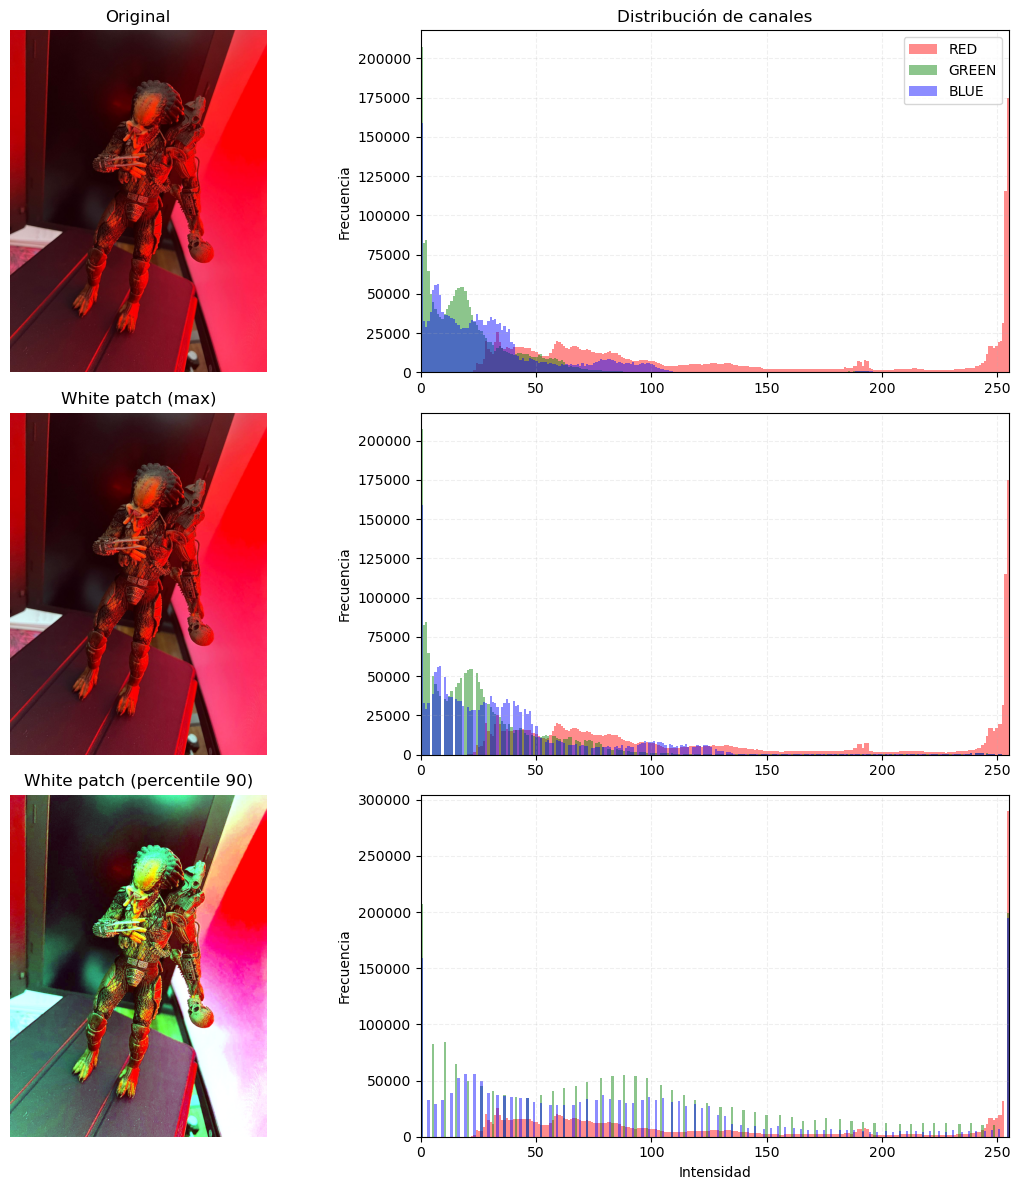

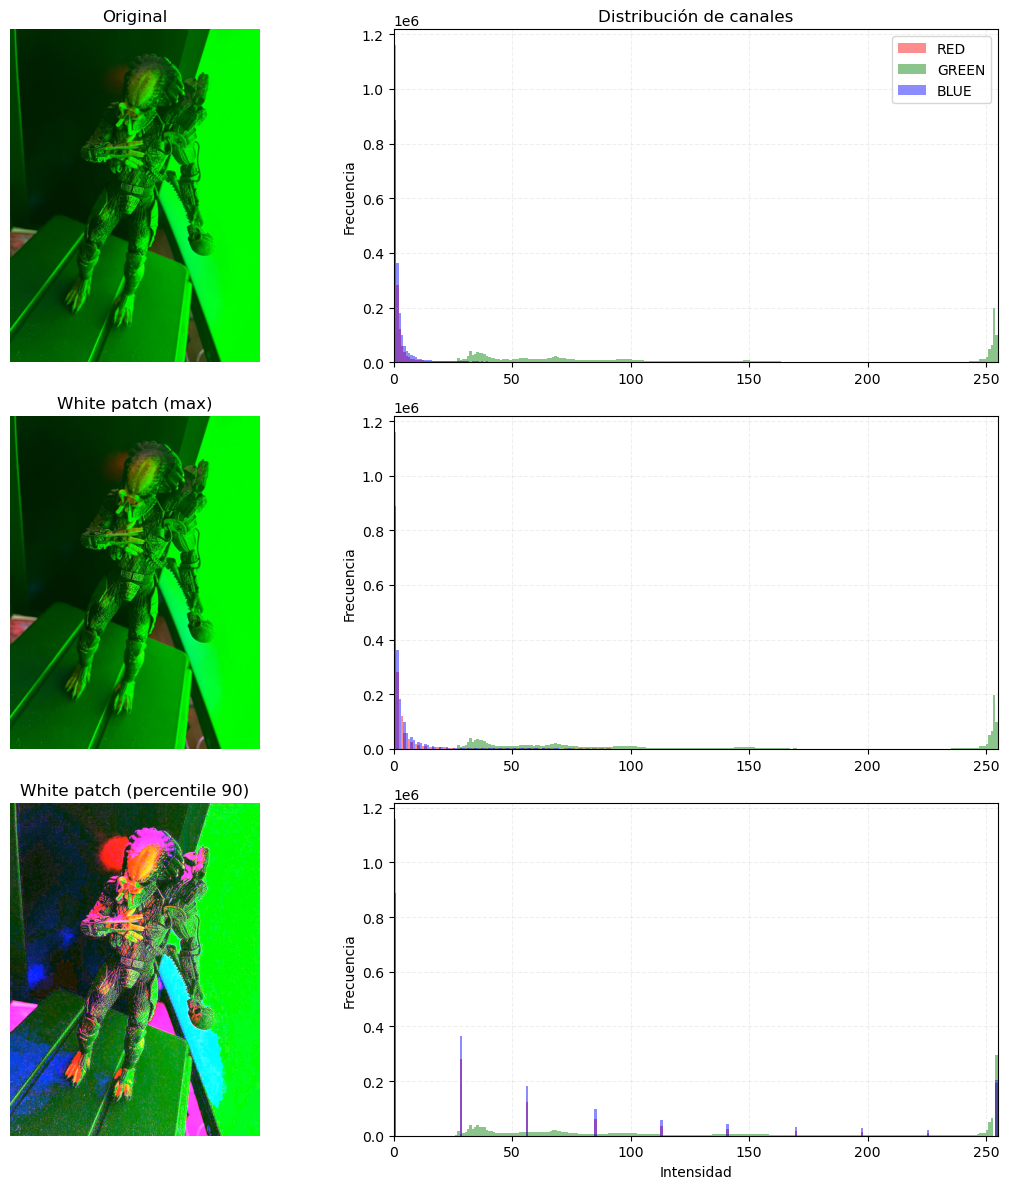

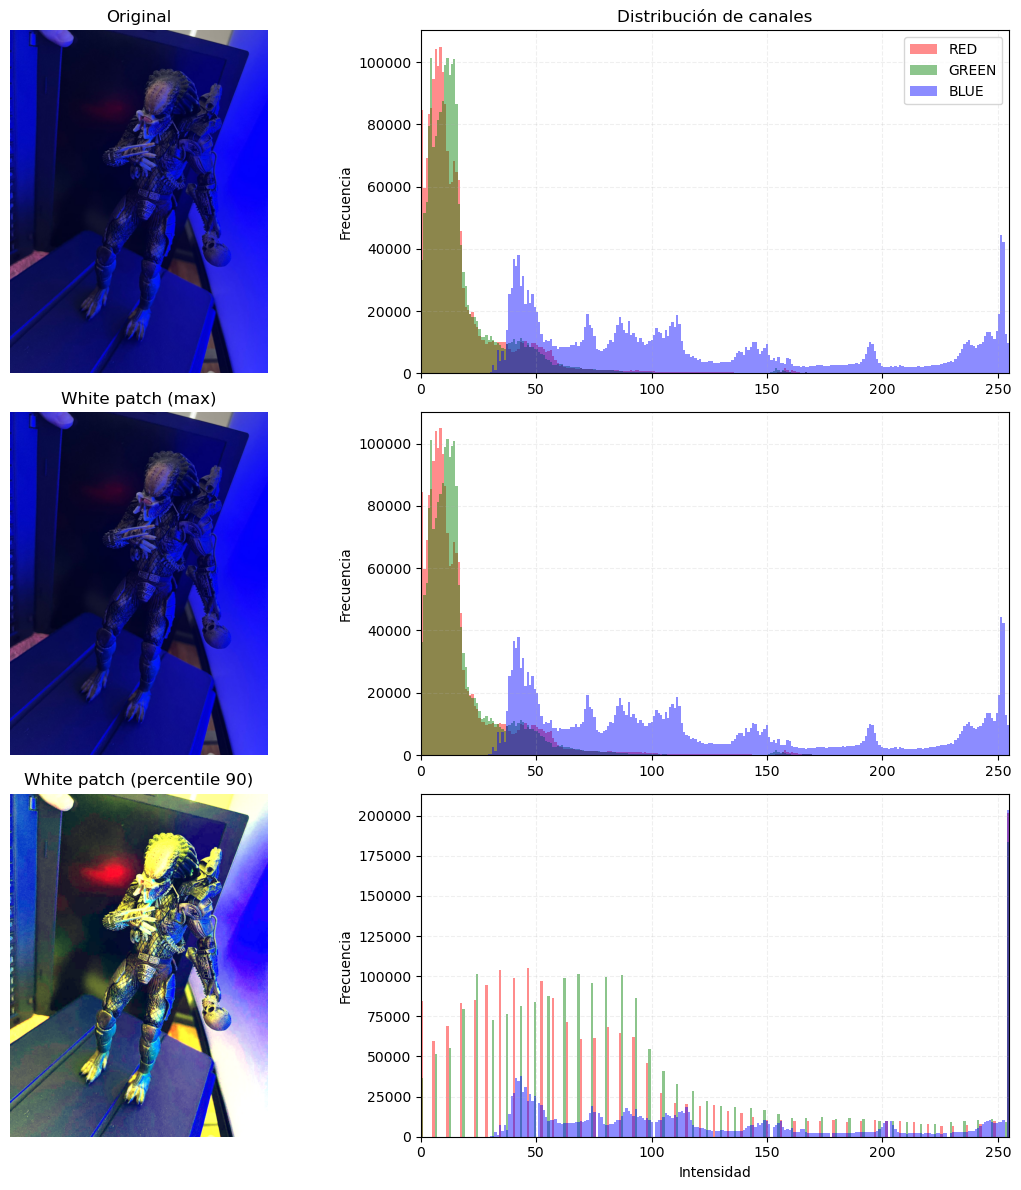

In [9]:
show_comparison(dpj_red,90)
show_comparison(dpj_green,90)
show_comparison(dpj_blue,90)


#### Discusión 
Análisis de las fotos del **Depredador formato .jpg**

Se puede observar que al procesar la misma imagen en formato JPG y PNG aparecen diferencias importantes en el desempeño de White Patch.
Esta diferencias se deben a que el formato JPG introduce compresión con pérdida de información y particularmente modifica los valores extremos. Esto último es notorio (independiente de las escalas) en los histogramas de las imágenes originales iluminadas con verde (.png vs .jpj). Se deduce que, como White Patch depende directamente de los valores máximos o percentiles altos de cada canal, modificación esta afecta la estimación de la iluminación.
En consecuencia, el método White Patch por máximo no tiene buen desempeño y la variante por percentil genera una corrección más agresiva y produce colores sobreexpuestos o irreales. Aún así hay zonas en la que logran resaltarse detalles que no se perciben en la imagen original.


### Parte 2:
1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCVen escala de grises y visualizarlas.
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘features’ a los histogramas?

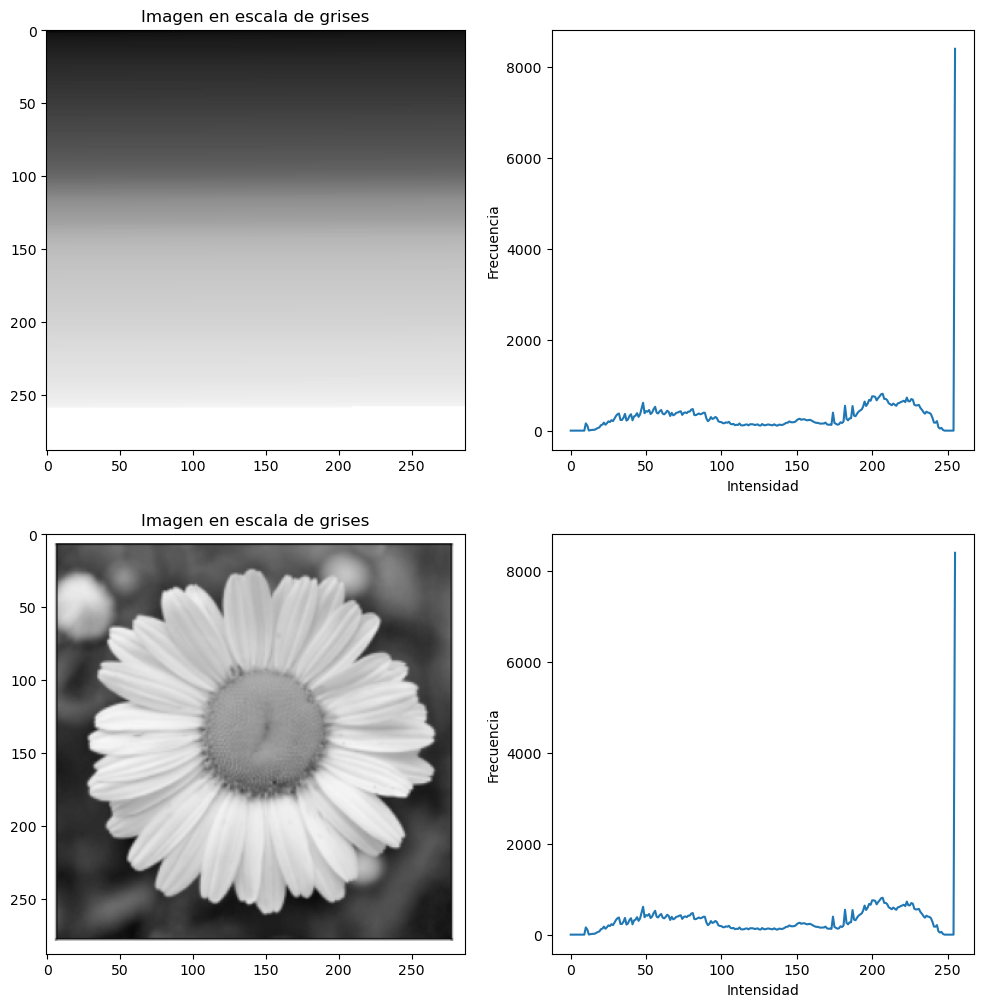

In [10]:
img1=cv.imread('img1_tp.png',cv.IMREAD_GRAYSCALE)
img2=cv.imread('img2_tp.png',cv.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(12, 12))
hist1,bins1=np.histogram(img1,256,[0,256])

ax1=fig.add_subplot(2,2,1)
ax1.imshow(img1,cmap='gray')
ax1.set_title("Imagen en escala de grises")

ax2=fig.add_subplot(2,2,2)
ax2.plot(hist1)
ax2.set_xlabel('Intensidad')
ax2.set_ylabel('Frecuencia')

hist2,bins2=np.histogram(img2,256,[0,256])

ax3=fig.add_subplot(2,2,3)
ax3.imshow(img2,cmap='gray')
ax3.set_title("Imagen en escala de grises")

ax4=fig.add_subplot(2,2,4)
ax4.plot(hist2)
ax4.set_xlabel('Intensidad')
ax4.set_ylabel('Frecuencia')

plt.show()

#### Discusión

Los histogramas al construirse únicamente a partir de la distribución de intensidades, pierden completamente la información espacial de la imagen. Esto implica que dos imágenes con contenidos visuales distintos pueden poseer histogramas muy similares, reduciendo su capacidad para discriminar adecuadamente clases complejas en el marco de un modelo de clasificación/detección.

Una alternativa más robusta podría ser emplear histogramas que incorporen información espacial, aunque la utilidad estos histogramas como features depende del problema específico y de la naturaleza de los patrones a distinguir.

Text(0.5, 1.0, 'Histogramas con información espacial')

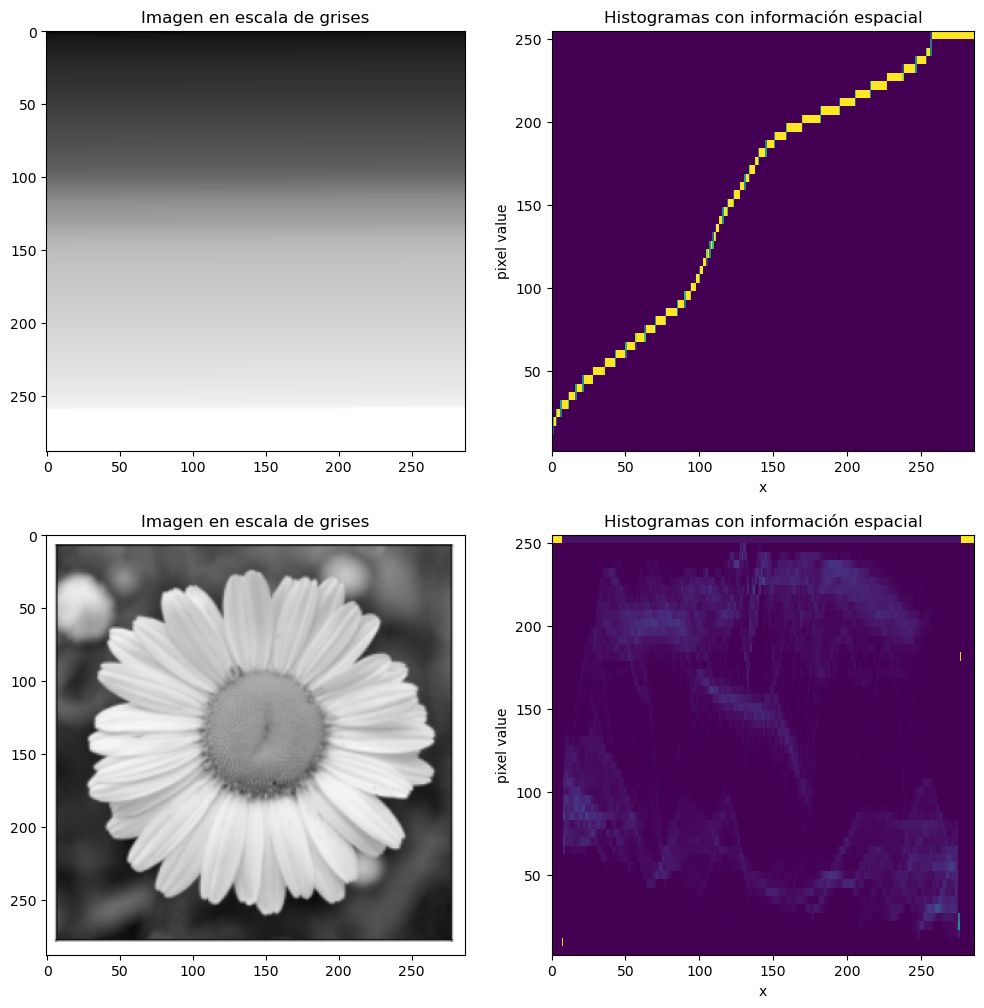

In [21]:
#Histogramas con información espacial
h, w = img1.shape
#Se crea un array en numpy de w x h para usarlo como eje en el histograma
xs = np.repeat(np.arange(w), h) 
#El otro eje del histograma, es la imagen aplanada
ys = img1.flatten() 

h1, w1 = img2.shape

xs1 = np.repeat(np.arange(w1), h1) 
ys1 = img2.flatten()

fig = plt.figure(figsize=(12, 12))


ax1=fig.add_subplot(2,2,1)
ax1.imshow(img1,cmap='gray')
ax1.set_title("Imagen en escala de grises")

ax2=fig.add_subplot(2,2,2)
ax2.hist2d(xs, ys, bins=[w1, 50])
ax2.set_xlabel("x")
ax2.set_ylabel("pixel value")
ax2.set_title("Histogramas con información espacial")

ax3=fig.add_subplot(2,2,3)
ax3.imshow(img2,cmap='gray')
ax3.set_title("Imagen en escala de grises")

ax4=fig.add_subplot(2,2,4)
ax4.hist2d(xs1, ys1, bins=[w, 50])
ax4.set_xlabel("x")
ax4.set_ylabel("pixel value")
ax4.set_title("Histogramas con información espacial")


Optando por un histograma con información espacial puede verse que aparecen diferencias significativas que dependen de la imagen. 